<a href="https://colab.research.google.com/github/TaeMD/ML-projects/blob/main/Covid19_Pneumonia_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! git clone https://github.com/education454/datasets.git

Cloning into 'datasets'...
remote: Enumerating objects: 2301, done.
remote: Total 2301 (delta 0), reused 0 (delta 0), pack-reused 2301
Receiving objects: 100% (2301/2301), 1.31 GiB | 24.44 MiB/s, done.
Checking out files: 100% (2295/2295), done.


In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

In [3]:
base_dir = '/content/datasets/Data'
train_covid = os.path.join(base_dir, 'train/COVID19')
train_normal = os.path.join(base_dir, 'train/NORMAL') 
test_covid = os.path.join(base_dir, 'test/COVID19')
test_normal = os.path.join(base_dir, 'test/NORMAL')

In [5]:
normal_length = len(os.listdir(train_normal))
covid_length = len(os.listdir(train_covid))

print('train normal cases:', len(os.listdir(train_normal)))
print('train covid cases:', len(os.listdir(train_covid)))
print('test normal cases:', len(os.listdir(test_normal)))
print('test covid cases:', len(os.listdir(test_covid)))

train normal cases: 1266
train covid cases: 545
test normal cases: 317
test covid cases: 167


# Split the train data into train and validation data manually (Optional) 

Normal train data into train and validation data

In [ ]:
nsplit = int(normal_length * 0.8)
csplit = int(covid_length * 0.8)
print(nsplit)
print(csplit)

In [ ]:
normal_file_list = os.listdir(train_normal)

In [ ]:
random.shuffle(normal_file_list)

train_normal_file_list = normal_file_list [:nsplit]
validation_normal_file_list = normal_file_list [nsplit:]
print(len(train_normal_file_list))
print(len(validation_normal_file_list))

In [ ]:
validation_dir = base_dir + '/validation'
validation_normal_dir = validation_dir + '/NORMAL'
validation_covid_dir = validation_dir + '/COVID19'

os.mkdir(validation_dir)
os.mkdir(validation_normal_dir)
os.mkdir(validation_covid_dir)

In [ ]:
for f in validation_normal_file_list:
  os.rename (os.path.join(base_train_normal,f), os.path.join(validation_normal_dir,f))

In [ ]:
len(os.listdir(validation_normal_dir))

Covid train data into train and validation data

In [ ]:
covid_file_list = os.listdir(train_covid)

In [ ]:
len(covid_file_list)

In [ ]:
random.shuffle(covid_file_list)

train_covid_file_list = covid_file_list [:csplit]
validation_covid_file_list = covid_file_list [csplit:]
print(len(train_covid_file_list))
print(len(validation_covid_file_list))

In [ ]:
for f in validation_covid_file_list:
  os.rename (os.path.join(train_covid, f), os.path.join(validation_covid_dir, f))

In [ ]:
len(os.listdir(validation_covid_dir))

# Data visualization

In [7]:
train_normal_files = os.listdir(train_normal)
train_covid_files = os.listdir(train_covid)

In [10]:
os.path.join(train_covid, train_covid_files[1])
os.path.join(train_normal, train_normal_files[10])

'/content/datasets/Data/train/NORMAL/NORMAL(91).jpg'

In [ ]:
fig, ax = plt.subplots (2,2, figsize=(10,10))

ax[0,0].imshow(load_img(os.path.join(train_covid, train_covid_files[1])))
ax[0,1].imshow(load_img(os.path.join(train_covid, train_covid_files[2])))
ax[1,0].imshow(load_img(os.path.join(train_normal, train_normal_files[10])))
ax[1,1].imshow(load_img(os.path.join(train_normal, train_normal_files[30])))

In [61]:
def show_picture(n):
  fig, axes = plt.subplots (2,n, figsize = (15,10))
  fig.tight_layout(pad=2.0)

  for i, ax in enumerate(axes.flatten()):
    if i <= n-1:
      ax.imshow(load_img(os.path.join(train_normal, train_normal_files[i])))
      ax.set_title(os.path.join(train_normal, train_normal_files[i]).split('/')[-1])
      ax.axis('Off')
    else:
      ax.imshow(load_img(os.path.join(train_covid, train_covid_files[i])))
      ax.set_title(os.path.join(train_covid, train_covid_files[i]).split('/')[-1])
      ax.axis('Off')

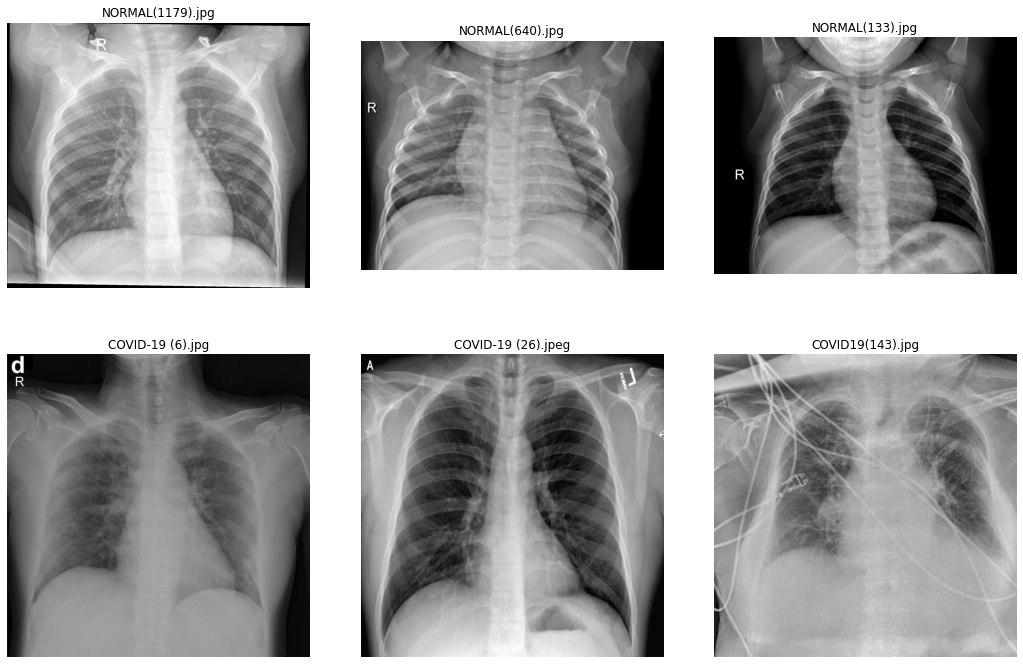

In [62]:
show_picture(3)

# Data Augmentation and Normalization